In [1]:
import numpy as np
import pandas as pd
import arviz as az
import scipy.stats as stats
import pymc as pm
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<!-- <center><img src="https://github.com/0xRevi/STA365-Group-Project/blob/main/project/introslide.png?raw=true" /></center> -->

## Research Question: 

<font size="6"> How can we quantitatively assess the impact of individual players and various gameplay scenarios on successful zone entries? </font>

## What are "Successful" Zone Entries

<font color="red">Zone Entry</font>: Attempts to move the puck into the offensive zone from the neutral zone.

<font color="red">Successful Zone Entries</font>: When a shot or goal occurs during a zone entry.

<center><b>Zone Entry Type: <font color="red">Dumped</font></b></center>

<!-- <center><img src="https://raw.githubusercontent.com/0xRevi/2024-STA365H1S/main/Zone%20Entries/Dumped.png" width="750" height="300"/></center> -->

<center><b>Zone Entry Type: <font color="red">Played</font></b></center>

<!-- <center><img src="https://raw.githubusercontent.com/0xRevi/2024-STA365H1S/main/Zone%20Entries/Played.png" width="750" height="300"/></center> -->

<center><b>Zone Entry Type: <font color="red">Carried</font></b></center>

<!-- <center><img src="https://raw.githubusercontent.com/0xRevi/2024-STA365H1S/main/Zone%20Entries/Carried.png" width="750" height="300"/></center> -->



<!-- <center><img src="https://github.com/0xRevi/STA365-Group-Project/blob/main/project/bmc_slide.png?raw=true" /></center> -->

# Data cleaning
Making two datasets, one for only the offensive team's players and one for the defendings team's players

In [ ]:
data = pd.read_csv('Data/zone_entries_with_players.csv')
zone_entries_df = data.iloc[:, [9] + list(range(31, 82))]
shifts_df = pd.read_csv('Data/BDC_2024_Womens_Shifts.csv')
players_to_remove = ['Aerin Frankel', 'Emerance Maschmeyer', 'Kristen Campbell', 'Nicole Hensley', 'Ann-Renee Desbiens']
shifts_df = shifts_df[~shifts_df['player_name'].isin(players_to_remove)]

# Get the player names and team names
player_teams_df = shifts_df[['team_name', 'player_name']].drop_duplicates().reset_index(drop=True)


In [44]:
def create_offensive_defensive_datasets(entries_df, player_teams_df):
    # Create empty DataFrames for offensive and defensive datasets with the same structure as entries_df
    offensive_df = entries_df.copy()
    defensive_df = entries_df.copy()
    
    # Go through each player in the player_teams_df and update the offensive and defensive datasets accordingly
    for _, row in player_teams_df.iterrows():
        player = row['player_name']
        team = row['team_name']
        
        # Check if the player is on the offensive team for each entry
        is_offensive = entries_df['Team'] == team
        is_defensive = ~is_offensive
        
        # Update the offensive_df by retaining player's presence only if they're on the offensive team
        offensive_df[player] = offensive_df[player].where(is_offensive, other=0)
        
        # Update the defensive_df by retaining player's presence only if they're on the defensive team
        defensive_df[player] = defensive_df[player].where(is_defensive, other=0)
    
    return offensive_df.drop("Team",axis=1), defensive_df.drop("Team",axis=1)


offensive_dataset, defensive_dataset = create_offensive_defensive_datasets(zone_entries_df, player_teams_df)




# Poisson Factorization 

In [64]:
with pm.Model() as poisson_factorization_offensive:

    # Priors for the factors
    zone_entry_factors = pm.Gamma('zone_entry_factors', alpha=1, beta=1, shape=(offensive_dataset.shape[0], 2))
    player_factors = pm.Gamma('player_factors', alpha=1, beta=1, shape=(offensive_dataset.shape[1], 2))

    # Expected value parameter for the Poisson likelihood
    rate = pm.math.dot(zone_entry_factors, player_factors.T)

    # Poisson likelihood for the observed data
    observed_counts = pm.Poisson('observed_counts', mu=rate, observed=offensive_dataset)

    # Sampling
    trace_offensive = pm.sample(return_inferencedata=True)
    
with pm.Model() as poisson_factorization_defensive:

    # Priors for the factors
    zone_entry_factors = pm.Gamma('zone_entry_factors', alpha=1, beta=1, shape=(defensive_dataset.shape[0], 2))
    player_factors = pm.Gamma('player_factors', alpha=1, beta=1, shape=(defensive_dataset.shape[1], 2))

    # Expected value parameter for the Poisson likelihood
    rate = pm.math.dot(zone_entry_factors, player_factors.T)

    # Poisson likelihood for the observed data
    observed_counts = pm.Poisson('observed_counts', mu=rate, observed=defensive_dataset)

    # Sampling
    trace_defensive = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


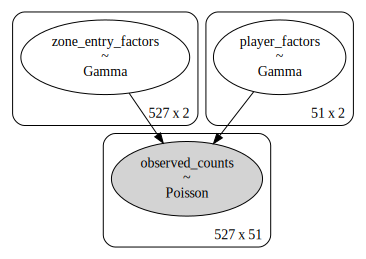

In [89]:
pm.model_to_graphviz(poisson_factorization_offensive)

In [108]:
# Extract the factor means
offensive_factors = trace_offensive.posterior['zone_entry_factors'].mean(dim=('chain', 'draw'))
defensive_factors = trace_defensive.posterior['zone_entry_factors'].mean(dim=('chain', 'draw'))

# Convert factors to a DataFrame
offensive_factors_df = pd.DataFrame(offensive_factors, columns=['Factor_1_Off', 'Factor_2_Off'])#, 'Factor_3_Off', 'Factor_4_Off', 'Factor_5_Off'
defensive_factors_df = pd.DataFrame(defensive_factors, columns=['Factor_1_Def', 'Factor_2_Def'])#, 'Factor_3_Def', 'Factor_4_Def', 'Factor_5_Def'
# Concatenate ze_with_players and zone_entry_factors_df along the columns axis
zone_entries_BMC_5_Off = pd.concat([data["zone_entry_success"], offensive_factors_df], axis=1)
zone_entries_BMC_5_Def = pd.concat([data["zone_entry_success"], offensive_factors_df], axis=1)

# Blessing of Multiple Causes Model

In [122]:
import pymc as pm
import numpy as np

num_players = offensive_dataset.shape[1]  # Number of players
num_factors = offensive_factors_df.shape[1]  # Number of latent factors derived from Poisson factorization
offending_players = offensive_dataset.values  # Binary indicators [rows x num_players] for offending players
defending_players = defensive_dataset.values  # Binary indicators [rows x num_players] for defending players
latent_factors_offense = offensive_factors_df.values  # Latent factors associated with offense [rows x num_factors]
latent_factors_defense = defensive_factors_df.values  # Latent factors associated with defense [rows x num_factors]
success = zone_entries_BMC_5_Off['zone_entry_success'].values  # Binary outcomes of zone entries [rows x 1]

player_names = offensive_dataset.columns  # player names

coords = {
    'player': player_names,
}

with pm.Model(coords=coords) as zone_entry_model:
    # Global intercept
    intercept = pm.Flat('intercept')
    
    # Hyperpriors for the standard deviations of player strengths
    sd_offense = pm.HalfCauchy('sd_offense', beta=2.5)
    sd_defense = pm.HalfCauchy('sd_defense', beta=2.5)
    
    # Player strength parameters as random effects
    offensive_coeff = pm.Normal('offensive_coeff', 0, sd_offense, dims='player')
    defensive_coeff = pm.Normal('defensive_coeff', 0, sd_defense, dims='player')
    
    # Latent factor weights
    factor_coeff_offense = pm.Normal('factor_coeff_offense', 0, 2, shape=num_factors)
    factor_coeff_defense = pm.Normal('factor_coeff_defense', 0, 2, shape=num_factors)
    
    # Linear combination of player indicators and latent factors
    logit_p = pm.invlogit(intercept + pm.math.dot(offending_players, offensive_coeff) 
                                    - pm.math.dot(defending_players, defensive_coeff)
                                    + pm.math.dot(latent_factors_offense, factor_coeff_offense) 
                                    - pm.math.dot(latent_factors_defense, factor_coeff_defense))
    
    # Model likelihood
    observed_success = pm.Bernoulli('observed_success', p=logit_p, observed=success)

with zone_entry_model:
    trace_zone_entry = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, sd_offense, sd_defense, offensive_coeff, defensive_coeff, factor_coeff_offense, factor_coeff_defense]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 323 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'offensive_coeff'}>,
        <Axes: title={'center': 'offensive_coeff'}>],
       [<Axes: title={'center': 'defensive_coeff'}>,
        <Axes: title={'center': 'defensive_coeff'}>],
       [<Axes: title={'center': 'factor_coeff_offense'}>,
        <Axes: title={'center': 'factor_coeff_offense'}>],
       [<Axes: title={'center': 'factor_coeff_defense'}>,
        <Axes: title={'center': 'factor_coeff_defense'}>],
       [<Axes: title={'center': 'sd_offense'}>,
        <Axes: title={'center': 'sd_offense'}>],
       [<Axes: title={'center': 'sd_defense'}>,
        <Axes: title={'center': 'sd_defense'}>]], dtype=object)

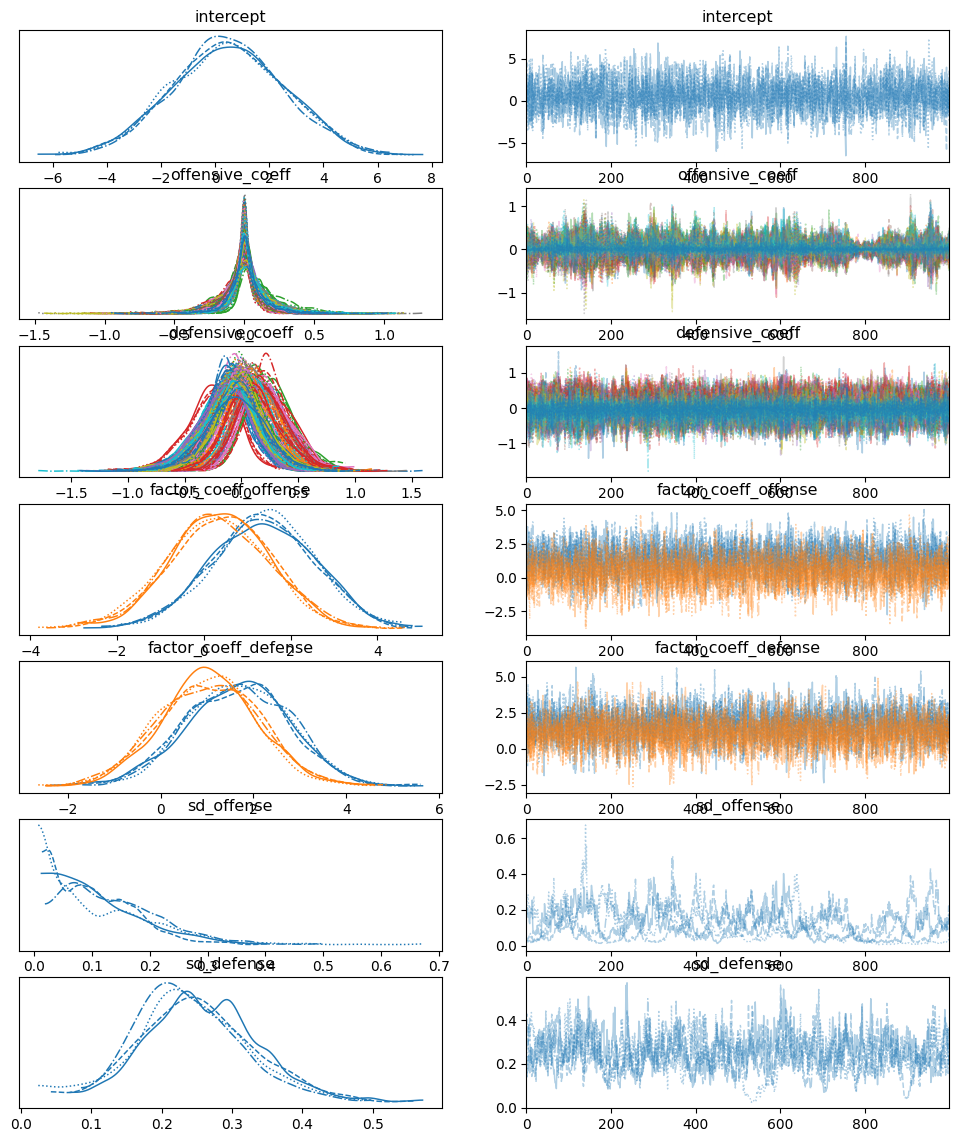

In [123]:
az.plot_trace(trace_zone_entry, compact=True)

<Axes: >

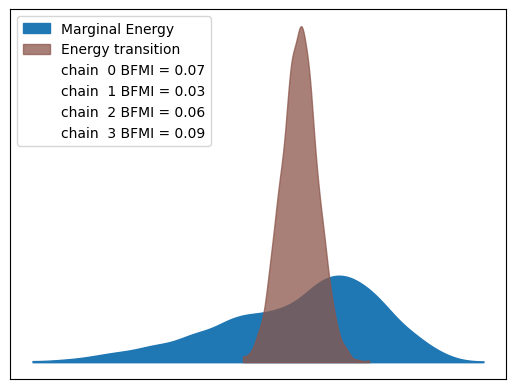

In [124]:
az.plot_energy(trace_zone_entry)


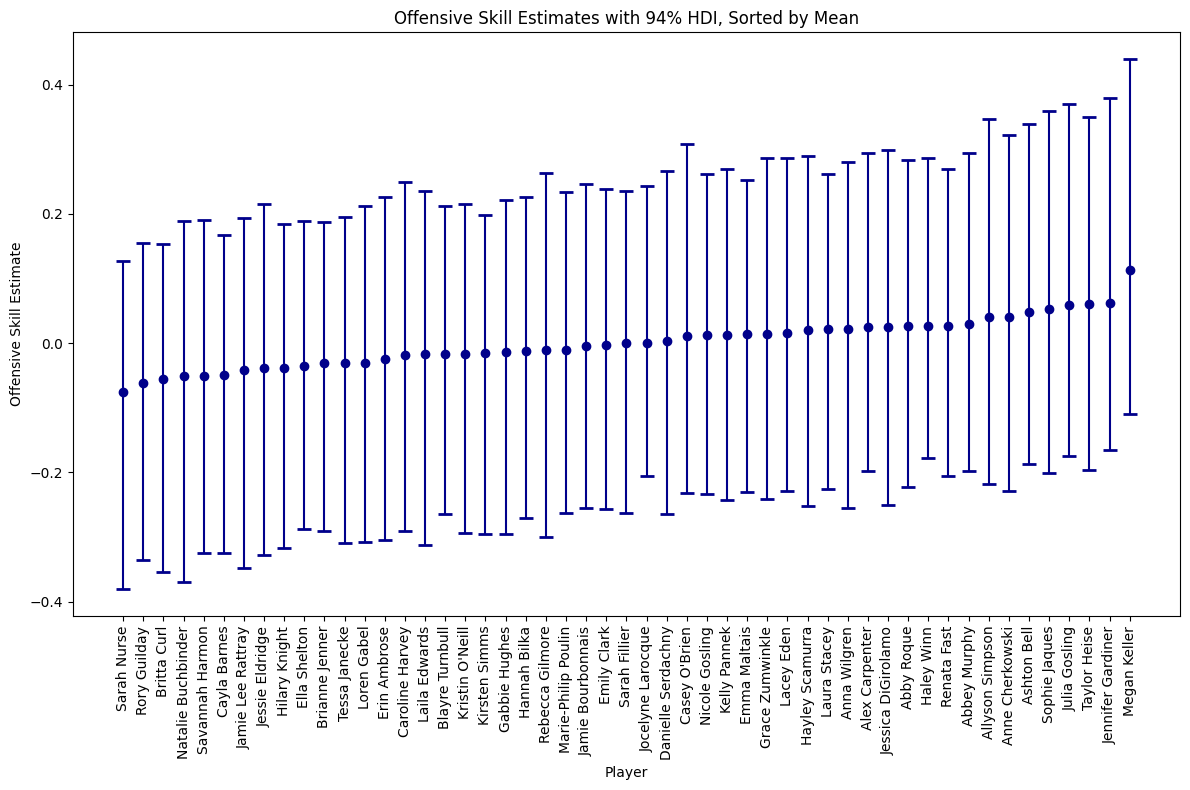

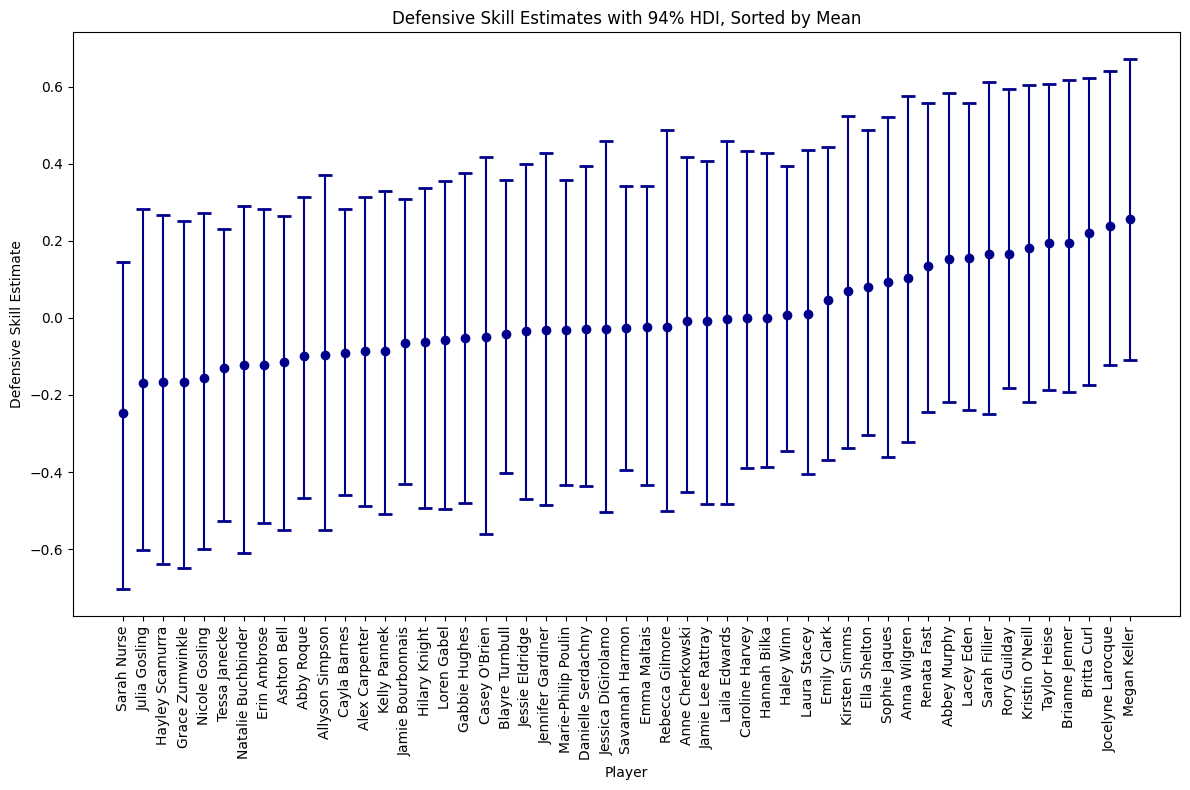

In [128]:
# Calculate summary statistics for ceofficients
summary_offensive = az.summary(trace_zone_entry, var_names=['offensive_coeff'], hdi_prob=0.94)
summary_offensive = summary_offensive.assign(names=offensive_dataset.columns)

summary_defensive = az.summary(trace_zone_entry, var_names=['defensive_coeff'], hdi_prob=0.94)
summary_defensive = summary_defensive.assign(names=offensive_dataset.columns)

# Sort the summary by mean values
summary_sorted_offensive = summary_offensive.sort_values(by='mean')
summary_sorted_defensive = summary_defensive.sort_values(by='mean')

# Extract means and HDI intervals after sorting
means_offensive, means_defensive = summary_sorted_offensive['mean'], summary_sorted_defensive['mean']
hdi_lower_offensive, hdi_lower_defensive = summary_sorted_offensive['hdi_3%'], summary_sorted_defensive['hdi_3%']
hdi_upper_offensive, hdi_upper_defensive = summary_sorted_offensive['hdi_97%'] , summary_sorted_defensive['hdi_97%']

# Calculate errors from mean to lower and upper bounds
errors_offensive = [means_offensive - hdi_lower_offensive, hdi_upper_offensive - means_offensive]
errors_defensive = [means_defensive - hdi_lower_defensive, hdi_upper_defensive - means_defensive]

# Generate a sequence of player names or IDs based on the sorted order
player_names_sorted_offensive = summary_sorted_offensive.names
player_names_sorted_defensive = summary_sorted_defensive.names

# Create error bars
plt.figure(figsize=(12, 8))
plt.errorbar(range(len(means_offensive)), means_offensive, yerr=errors_offensive, fmt='o', capsize=5, capthick=2, color='darkblue')

# Update the x-ticks to reflect the sorted player names
plt.xticks(range(len(player_names_sorted_offensive)), player_names_sorted_offensive, rotation='vertical')

plt.xlabel('Player')
plt.ylabel('Offensive Skill Estimate')
plt.title('Offensive Skill Estimates with 94% HDI, Sorted by Mean')
plt.tight_layout()  # Adjust layout to make room for the rotated labels
plt.show()


# Create error bars
plt.figure(figsize=(12, 8))
plt.errorbar(range(len(means_defensive)), means_defensive, yerr=errors_defensive, fmt='o', capsize=5, capthick=2, color='darkblue')

# Update the x-ticks to reflect the sorted player names
plt.xticks(range(len(player_names_sorted_defensive)), player_names_sorted_defensive, rotation='vertical')

plt.xlabel('Player')
plt.ylabel('Defensive Skill Estimate')
plt.title('Defensive Skill Estimates with 94% HDI, Sorted by Mean')
plt.tight_layout()  # Adjust layout to make room for the rotated labels
plt.show()

## Predictive checks

### Offense

In [92]:
# Set the random seed for reproducibility
np.random.seed(2)
num_mask = 3
# Example mask creation (conceptual, adjust as needed)
mask = np.ones_like(offensive_dataset, dtype=bool)
for i in range(offensive_dataset.shape[0]):
    mask_indices = np.random.choice(offensive_dataset.shape[1], num_mask, replace=False)
    mask[i, mask_indices] = False


In [137]:
with pm.Model() as poisson_factorization:

    # Priors for the factors
    zone_entry_factors = pm.Gamma('zone_entry_factors', alpha=1, beta=1, shape=(offensive_dataset.shape[0], 2))
    player_factors = pm.Gamma('player_factors', alpha=1, beta=1, shape=(offensive_dataset.shape[1], 2))

    # Expected value parameter for the Poisson likelihood
    rate = pm.math.dot(zone_entry_factors, player_factors.T)

    # Poisson likelihood for the observed data
    observed_counts = pm.Poisson('observed_counts', mu=rate[mask], observed=np.array(offensive_dataset)[mask])

    # Sampling
    trace_held_out = pm.sample(return_inferencedata=True)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 129 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [138]:
# Getting and reshaping the latent factors
zone_entry_factors = trace_held_out.posterior["zone_entry_factors"].values
player_factors = trace_held_out.posterior["player_factors"].values

# Calculate the new shape for the array after flattening the first axis
new_shape = (-1,) + zone_entry_factors.shape[2:]
new_shapepf = (-1,) + player_factors.shape[2:]
# Reshape the array to flatten only the first two axes (chains and draws)
zone_entry_factors = zone_entry_factors.reshape(new_shape)
player_factors = player_factors.reshape(new_shapepf)


# Posterior samples for the held-out data

# Number of posterior samples (combined from all chains)
n_samples = zone_entry_factors.shape[0]

# Initialize an array to store the predicted counts for the held-out data
predicted_counts_held_out = np.zeros((n_samples, offensive_dataset.shape[0], offensive_dataset.shape[1]))

# Calculate the rates using the latent factors and sample from the Poisson for each sample
for i in range(n_samples):
    # Compute the rate for this sample
    rate = np.dot(zone_entry_factors[i], player_factors[i].T)
    
    # Sample from a Poisson distribution with the computed rates for the held-out data
    predicted_counts_held_out[i] = np.random.poisson(rate)


In [139]:
actual_discrepancy = discrepancy_function(zone_entry_factors,player_factors, offensive_dataset, mask, num_mask)
num_iter = 100
replicated_discrepancy = np.zeros((offensive_dataset.shape[0],num_iter))
for i in range(num_iter):
    print(i, end='\r')
    replicated_discrepancy[:,i] = discrepancy_function(zone_entry_factors,player_factors, predicted_counts_held_out[i], mask, num_mask)

In [142]:
# Calculate the prediction score
score = np.mean(replicated_discrepancy < actual_discrepancy[:, np.newaxis], axis =1)

# Print the result
print(np.mean(score))

0.20624288425047438


### Defense

In [140]:
with pm.Model() as poisson_factorization:

    # Priors for the factors
    zone_entry_factors = pm.Gamma('zone_entry_factors', alpha=1, beta=1, shape=(offensive_dataset.shape[0], 2))
    player_factors = pm.Gamma('player_factors', alpha=1, beta=1, shape=(offensive_dataset.shape[1], 2))

    # Expected value parameter for the Poisson likelihood
    rate = pm.math.dot(zone_entry_factors, player_factors.T)

    # Poisson likelihood for the observed data
    observed_counts = pm.Poisson('observed_counts', mu=rate[mask], observed=np.array(defensive_dataset)[mask])

    # Sampling
    trace_held_out = pm.sample(return_inferencedata=True)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 117 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [141]:
# Getting and reshaping the latent factors
zone_entry_factors = trace_held_out.posterior["zone_entry_factors"].values
player_factors = trace_held_out.posterior["player_factors"].values

# Calculate the new shape for the array after flattening the first axis
new_shape = (-1,) + zone_entry_factors.shape[2:]
new_shapepf = (-1,) + player_factors.shape[2:]
# Reshape the array to flatten only the first two axes (chains and draws)
zone_entry_factors = zone_entry_factors.reshape(new_shape)
player_factors = player_factors.reshape(new_shapepf)


# Posterior samples for the held-out data

# Number of posterior samples (combined from all chains)
n_samples = zone_entry_factors.shape[0]

# Initialize an array to store the predicted counts for the held-out data
predicted_counts_held_out = np.zeros((n_samples, offensive_dataset.shape[0], offensive_dataset.shape[1]))

# Calculate the rates using the latent factors and sample from the Poisson for each sample
for i in range(n_samples):
    # Compute the rate for this sample
    rate = np.dot(zone_entry_factors[i], player_factors[i].T)
    
    # Sample from a Poisson distribution with the computed rates for the held-out data
    predicted_counts_held_out[i] = np.random.poisson(rate)


In [143]:
actual_discrepancy = discrepancy_function(zone_entry_factors,player_factors, offensive_dataset, mask, num_mask)
num_iter = 100
replicated_discrepancy = np.zeros((offensive_dataset.shape[0],num_iter))
for i in range(num_iter):
    print(i, end='\r')
    replicated_discrepancy[:,i] = discrepancy_function(zone_entry_factors,player_factors, predicted_counts_held_out[i], mask, num_mask)

In [104]:
# Calculate the prediction score
score = np.mean(replicated_discrepancy < actual_discrepancy[:, np.newaxis], axis =1)

# Print the result
print(np.mean(score))

0.2111764705882353


# Helper Functions

In [65]:
def discrepancy_function(zone_entry_factors,player_factors, data, mask, num_heldout):
    data = np.array(data)
    # Initialize the array to store the observed log probability
    observed_log_prob = np.zeros([zone_entry_factors.shape[1],zone_entry_factors.shape[0]]) # zone entries x num samples

    for i in range(zone_entry_factors.shape[0]):
        # Calculate the rate matrix
        rate = np.dot(zone_entry_factors[i], player_factors[i].T)
        
        # Calculate the log probability of the held-out data under the model
        held_out_rate = rate[~mask].reshape(rate.shape[0], num_heldout)
        held_out_data = data[~mask].reshape(data.shape[0], num_heldout)
        
        observed_log_prob[:,i] = stats.poisson.logpmf(held_out_data, held_out_rate).sum(axis=1)
        
    # Compute the discrepancy function for the actual held-out data
    discrepancy = np.mean(observed_log_prob, axis=1)
    
    return discrepancy

In [67]:
def make_factorization_model(data, mask, num_factors):
    with pm.Model() as poisson_factorization:

        # Priors for the factors
        zone_entry_factors = pm.Gamma('zone_entry_factors', alpha=1, beta=1, shape=(data.shape[0], num_factors))
        player_factors = pm.Gamma('player_factors', alpha=1, beta=1, shape=(data.shape[1], num_factors))

        # Expected value parameter for the Poisson likelihood
        rate = pm.math.dot(zone_entry_factors, player_factors.T)

        # Poisson likelihood for the observed data
        observed_counts = pm.Poisson('observed_counts', mu=rate[mask], observed=np.array(data)[mask])

        # Sampling
        trace_held_out = pm.sample(return_inferencedata=True)
    return trace_held_out

In [99]:
# Calculate summary statistics for coefficients
players_positions = {
    'Blayre Turnbull': 'F',
    'Hilary Knight': 'F',
    'Sarah Fillier': 'F',
    'Hannah Bilka': 'F',
    'Brianne Jenner': 'F',
    'Alex Carpenter': 'F',
    'Natalie Buchbinder': 'D',
    'Jessie Eldridge': 'F',
    'Grace Zumwinkle': 'F',
    'Jamie Lee Rattray': 'F',
    'Emma Maltais': 'F',
    'Cayla Barnes': 'D',
    'Ashton Bell': 'D',
    'Emily Clark': 'F',
    'Haley Winn': 'D',
    'Abbey Murphy': 'F',
    'Sarah Nurse': 'F',
    'Megan Keller': 'D',
    'Lacey Eden': 'F',
    'Renata Fast': 'D',
    'Laura Stacey': 'F',
    'Julia Gosling': 'F',
    'Jamie Bourbonnais': 'D',
    'Tessa Janecke': 'F',
    'Abby Roque': 'F',
    'Taylor Heise': 'F',
    'Ella Shelton': 'D',
    'Savannah Harmon': 'D',
    'Marie-Philip Poulin': 'F',
    'Hayley Scamurra': 'F',
    'Gabbie Hughes': 'F',
    'Jessica DiGirolamo': 'D',
    "Kristin O'Neill": 'F',
    'Erin Ambrose': 'D',
    'Britta Curl': 'F',
    'Kelly Pannek': 'F',
    'Jocelyne Larocque': 'D',
    'Rory Guilday': 'D',
    'Sophie Jaques': 'D',
    'Laila Edwards': 'F',
    'Jennifer Gardiner': 'F',
    'Caroline Harvey': 'D',
    'Loren Gabel': 'F',
    'Kirsten Simms': 'F',
    'Danielle Serdachny': 'F',
    'Anna Wilgren': 'D',
    'Anne Cherkowski': 'F',
    'Allyson Simpson': 'D'
}


def plot_rankings(trace):
    summary_offensive = az.summary(trace, var_names=['offensive_coeff'], hdi_prob=0.94)
    summary_offensive = summary_offensive.assign(names=offensive_dataset.columns)

    summary_defensive = az.summary(trace, var_names=['defensive_coeff'], hdi_prob=0.94)
    summary_defensive = summary_defensive.assign(names=offensive_dataset.columns)

    # Sort the summary by mean values
    summary_sorted_offensive = summary_offensive.sort_values(by='mean')
    summary_sorted_defensive = summary_defensive.sort_values(by='mean')

    # Extract means and HDI intervals after sorting
    means_offensive, means_defensive = summary_sorted_offensive['mean'], summary_sorted_defensive['mean']
    hdi_lower_offensive, hdi_lower_defensive = summary_sorted_offensive['hdi_3%'], summary_sorted_defensive['hdi_3%']
    hdi_upper_offensive, hdi_upper_defensive = summary_sorted_offensive['hdi_97%'] , summary_sorted_defensive['hdi_97%']

    # Calculate errors from mean to lower and upper bounds
    errors_offensive = [means_offensive - hdi_lower_offensive, hdi_upper_offensive - means_offensive]
    errors_defensive = [means_defensive - hdi_lower_defensive, hdi_upper_defensive - means_defensive]


    plt.figure(figsize=(12, 8))
    for i, player in enumerate(summary_sorted_offensive['names']):
        color = 'blue' if players_positions.get(player, 'F') == 'F' else 'red'
        plt.errorbar(i, means_offensive[i], yerr=[[errors_offensive[0][i]], [errors_offensive[1][i]]], 
                     fmt='o', capsize=5, capthick=2, color=color)
    plt.xticks(range(len(summary_sorted_offensive['names'])), summary_sorted_offensive['names'], rotation='vertical')
    plt.xlabel('Player')
    plt.ylabel('Offensive Skill Estimate')
    plt.title('Offensive Skill Estimates with 94% HDI, Sorted by Mean')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    for i, player in enumerate(summary_sorted_defensive['names']):
        color = 'blue' if players_positions.get(player, 'F') == 'F' else 'red'
        plt.errorbar(i, means_defensive[i], yerr=[[errors_defensive[0][i]], [errors_defensive[1][i]]], 
                     fmt='o', capsize=5, capthick=2, color=color)
    plt.xticks(range(len(summary_sorted_defensive['names'])), summary_sorted_defensive['names'], rotation='vertical')
    plt.xlabel('Player')
    plt.ylabel('Defensive Skill Estimate')
    plt.title('Defensive Skill Estimates with 94% HDI, Sorted by Mean')
    plt.tight_layout()
    plt.show()

# Final Model 


In [32]:
import numpy as np
import pandas as pd
import arviz as az
import scipy.stats as stats
import pymc as pm
import matplotlib.pyplot as plt

data = pd.read_csv('final_data.csv')
offensive_dataset = pd.read_csv('final_off_data.csv')
defensive_dataset = pd.read_csv('final_def_data.csv')
offensive_factors_df = pd.read_csv('final_off_factors.csv')
defensive_factors_df = pd.read_csv('final_def_factors.csv')

num_players = offensive_dataset.shape[1]  # Number of players
num_factors = offensive_factors_df.shape[1]  # Number of latent factors derived from Poisson factorization
offending_players = offensive_dataset.values  # Binary indicators [rows x num_players] for offending players
defending_players = defensive_dataset.values  # Binary indicators [rows x num_players] for defending players
latent_factors_offense = offensive_factors_df.values  # Latent factors associated with offense [rows x num_factors]
latent_factors_defense = defensive_factors_df.values  # Latent factors associated with defense [rows x num_factors]
success = data['zone_entry_success'].values  # Binary outcomes of zone entries [rows x 1]
X = data.drop(['zone_entry_success','player_id','Team_Women - Canada','Entry_Type_Dumped','Period_1','Y_coordinate_centered'], axis=1) # Covariates

player_names = offensive_dataset.columns  # player names
X_columns = X.columns
coords = {
    'player': player_names,
    'X_names': X_columns,
}


## Preliminary model


In [92]:
with pm.Model(coords=coords) as prelim_model:

    # Fixed effects and intercept
    intercept = pm.Flat('intercept')
    betas = pm.Normal('betas', mu=0, sigma=2, dims='X_names')
    
    # Linear combination of player indicators and latent factors
    logit_p = pm.math.invlogit(intercept + pm.math.dot(X, betas))

    # Model likelihood
    observed_success = pm.Bernoulli('observed_success', p=logit_p, observed=success)

    trace_prelim_model = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


In [93]:
player_ids = pd.read_csv('final_data.csv')['player_id'].astype('category').cat.codes.values

with pm.Model(coords=coords) as prelim_model_players:

    # Fixed effects and intercept
    intercept = pm.Flat('intercept')
    betas = pm.Normal('betas', mu=0, sigma=2, dims='X_names')
    # Random intercepts for players
    sigma_player = pm.HalfNormal('sigma_player', sigma=1)
    intercepts_player = pm.Normal('intercepts_player', mu=0, sigma=sigma_player,
                                  shape=num_players)
    
    # Linear combination of player indicators and latent factors
    logit_p = pm.math.invlogit(intercept + pm.math.dot(X, betas)+ intercepts_player[player_ids])

    # Model likelihood
    observed_success = pm.Bernoulli('observed_success', p=logit_p, observed=success)

    trace_prelim_model_players = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, betas, sigma_player, intercepts_player]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Full Model with BMC and Covariates

### Predictive Score

#### Creating Mask

In [71]:
# Set the random seed for reproducibility
np.random.seed(2)
num_mask = 3
# Example mask creation (conceptual, adjust as needed)
mask = np.ones_like(offensive_dataset, dtype=bool)
for i in range(offensive_dataset.shape[0]):
    mask_indices = np.random.choice(offensive_dataset.shape[1], num_mask, replace=False)
    mask[i, mask_indices] = False


In [ ]:
def make_factorization_model(data, mask, num_factors):
    with pm.Model() as poisson_factorization:

        # Priors for the factors
        zone_entry_factors = pm.Gamma('zone_entry_factors', alpha=1, beta=1, shape=(data.shape[0], num_factors))
        player_factors = pm.Gamma('player_factors', alpha=1, beta=1, shape=(data.shape[1], num_factors))

        # Expected value parameter for the Poisson likelihood
        rate = pm.math.dot(zone_entry_factors, player_factors.T)

        # Poisson likelihood for the observed data
        observed_counts = pm.Poisson('observed_counts', mu=rate[mask], observed=np.array(data)[mask])

        # Sampling
        trace_held_out = pm.sample(return_inferencedata=True)
    return trace_held_out

#### Calculating predictive scores for various number of latent factors.

In [86]:
predictive_checks_offense = np.zeros(5)
for i,num_factors in enumerate([2,5,10,15,20]):
    trace_held_out = make_factorization_model(offensive_dataset, mask, num_factors)
    # Getting and reshaping the latent factors
    zone_entry_factors = trace_held_out.posterior["zone_entry_factors"].values
    player_factors = trace_held_out.posterior["player_factors"].values

    # Calculate the new shape for the array after flattening the first axis
    new_shape = (-1,) + zone_entry_factors.shape[2:]
    new_shapepf = (-1,) + player_factors.shape[2:]
    # Reshape the array to flatten only the first two axes (chains and draws)
    zone_entry_factors = zone_entry_factors.reshape(new_shape)
    player_factors = player_factors.reshape(new_shapepf)

    # Posterior samples for the held-out data

    # Number of posterior samples (combined from all chains)
    n_samples = zone_entry_factors.shape[0]

    # Initialize an array to store the predicted counts for the held-out data
    predicted_counts_held_out = np.zeros((n_samples, offensive_dataset.shape[0], offensive_dataset.shape[1]))

    # Calculate the rates using the latent factors and sample from the Poisson for each sample
    for j in range(n_samples):
        # Compute the rate for this sample
        rate = np.dot(zone_entry_factors[j], player_factors[j].T)
        
        # Sample from a Poisson distribution with the computed rates for the held-out data
        predicted_counts_held_out[j] = np.random.poisson(rate)
    
    actual_discrepancy = discrepancy_function(zone_entry_factors,player_factors, offensive_dataset, mask, num_mask)
    num_iter = 100
    replicated_discrepancy = np.zeros((offensive_dataset.shape[0],num_iter))
    for k in range(num_iter):
        print(k, end='\r')
        replicated_discrepancy[:,k] = discrepancy_function(zone_entry_factors,player_factors, predicted_counts_held_out[k], mask, num_mask)

    # Calculate the prediction score
    score = np.mean(replicated_discrepancy < actual_discrepancy[:, np.newaxis], axis =1)

    # Print the result
    predictive_checks_offense[i] = np.mean(score)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 238 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 282 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 315 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 353 seconds.


In [78]:
predictive_checks_defense = np.zeros(5)
for i,num_factors in enumerate([2,5,10,15,20]):
    trace_held_out = make_factorization_model(defensive_dataset, mask, num_factors)
    # Getting and reshaping the latent factors
    zone_entry_factors = trace_held_out.posterior["zone_entry_factors"].values
    player_factors = trace_held_out.posterior["player_factors"].values

    # Calculate the new shape for the array after flattening the first axis
    new_shape = (-1,) + zone_entry_factors.shape[2:]
    new_shapepf = (-1,) + player_factors.shape[2:]
    # Reshape the array to flatten only the first two axes (chains and draws)
    zone_entry_factors = zone_entry_factors.reshape(new_shape)
    player_factors = player_factors.reshape(new_shapepf)

    # Posterior samples for the held-out data

    # Number of posterior samples (combined from all chains)
    n_samples = zone_entry_factors.shape[0]

    # Initialize an array to store the predicted counts for the held-out data
    predicted_counts_held_out = np.zeros((n_samples, offensive_dataset.shape[0], offensive_dataset.shape[1]))

    # Calculate the rates using the latent factors and sample from the Poisson for each sample
    for j in range(n_samples):
        # Compute the rate for this sample
        rate = np.dot(zone_entry_factors[j], player_factors[j].T)
        
        # Sample from a Poisson distribution with the computed rates for the held-out data
        predicted_counts_held_out[j] = np.random.poisson(rate)
    
    actual_discrepancy = discrepancy_function(zone_entry_factors,player_factors, defensive_dataset, mask, num_mask)
    num_iter = 100
    replicated_discrepancy = np.zeros((offensive_dataset.shape[0],num_iter))
    for k in range(num_iter):
        print(k, end='\r')
        replicated_discrepancy[:,k] = discrepancy_function(zone_entry_factors,player_factors, predicted_counts_held_out[k], mask, num_mask)

    # Calculate the prediction score
    score = np.mean(replicated_discrepancy < actual_discrepancy[:, np.newaxis], axis =1)

    # Print the result
    predictive_checks_defense[i] = np.mean(score)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 123 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 227 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 262 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 174 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zone_entry_factors, player_factors]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 225 seconds.


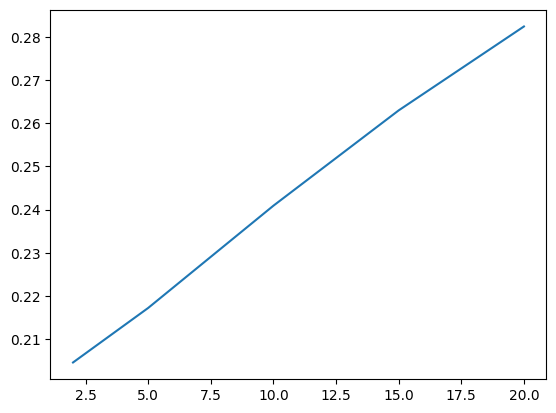

In [88]:
import pandas as pd

pc_off = predictive_checks_offense
plt.plot([2,5,10,15,20], predictive_checks_offense, label='Offensive')

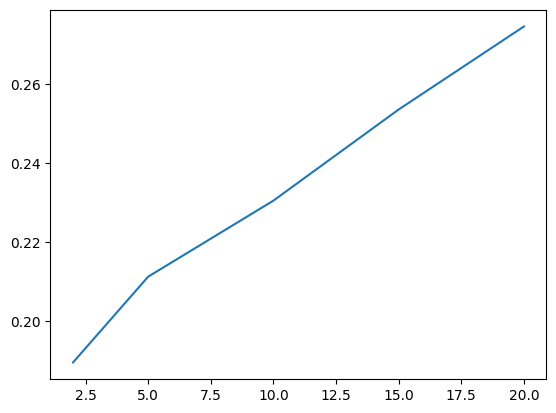

In [84]:
pc_def = predictive_checks_defense

plt.plot([2,5,10,15,20], predictive_checks_defense, label='Defensive')

### Model with Blessing of Multiple Causes

In [34]:

with pm.Model(coords=coords) as full_model_normal:

    # Fixed effects and intercept
    intercept = pm.Flat('intercept')
    betas = pm.Normal('betas', mu=0, sigma=2, dims='X_names')

    # Hyperpriors for the standard deviations of player strengths
    sd_offense = pm.HalfCauchy('sd_offense', beta=2.5)
    sd_defense = pm.HalfCauchy('sd_defense', beta=2.5)
    
    # Player strength parameters as random effects
    offensive_coeff = pm.Normal('offensive_coeff', 0, sd_offense, dims='player')
    defensive_coeff = pm.Normal('defensive_coeff', 0, sd_defense, dims='player')
    
    # Latent factor weights
    factor_coeff_offense = pm.Normal('factor_coeff_offense', 0, 2, shape=num_factors)
    factor_coeff_defense = pm.Normal('factor_coeff_defense', 0, 2, shape=num_factors)
    
    # Linear combination of player indicators and latent factors
    logit_p = pm.math.invlogit(intercept + pm.math.dot(offending_players, offensive_coeff) 
                                    - pm.math.dot(defending_players, defensive_coeff)
                                    + pm.math.dot(latent_factors_offense, factor_coeff_offense) 
                                    - pm.math.dot(latent_factors_defense, factor_coeff_defense)
                                    + pm.math.dot(X, betas))

    # Model likelihood
    observed_success = pm.Bernoulli('observed_success', p=logit_p, observed=success)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, betas, sd_offense, sd_defense, offensive_coeff, defensive_coeff, factor_coeff_offense, factor_coeff_defense]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1119 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


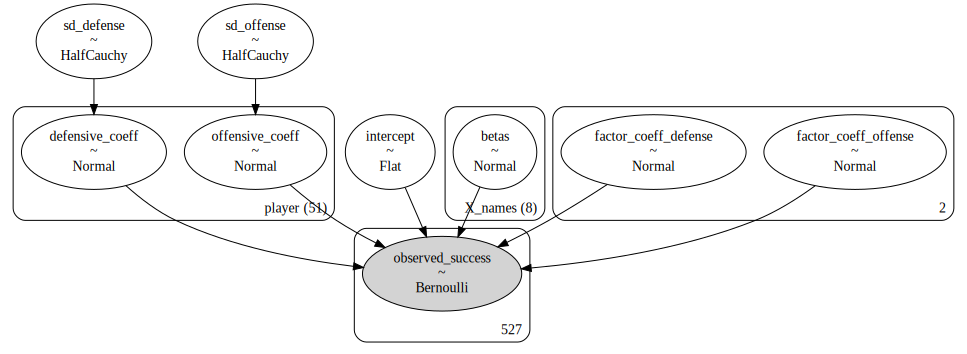

In [62]:
pm.model_to_graphviz(full_model_normal)

In [ ]:

with full_model_normal:
    trace_full_model_normal = pm.sample(return_inferencedata=True)

In [35]:
with pm.Model(coords=coords) as full_model_laplace:

    # Fixed effects and intercept
    intercept = pm.Flat('intercept')
    betas = pm.Laplace('betas', mu=0, b=2, dims='X_names')

    # Hyperpriors for the standard deviations of player strengths
    sd_offense = pm.HalfCauchy('sd_offense', beta=2.5)
    sd_defense = pm.HalfCauchy('sd_defense', beta=2.5)
    
    # Player strength parameters as random effects
    offensive_coeff = pm.Laplace('offensive_coeff', 0, sd_offense, dims='player')
    defensive_coeff = pm.Laplace('defensive_coeff', 0, sd_defense, dims='player')
    
    # Latent factor weights
    factor_coeff_offense = pm.Normal('factor_coeff_offense', 0, 2, shape=num_factors)
    factor_coeff_defense = pm.Normal('factor_coeff_defense', 0, 2, shape=num_factors)
    
    # Linear combination of player indicators and latent factors
    logit_p = pm.math.invlogit(intercept + pm.math.dot(offending_players, offensive_coeff) 
                                    - pm.math.dot(defending_players, defensive_coeff)
                                    + pm.math.dot(latent_factors_offense, factor_coeff_offense) 
                                    - pm.math.dot(latent_factors_defense, factor_coeff_defense)
                                    + pm.math.dot(X, betas))

    # Model likelihood
    observed_success = pm.Bernoulli('observed_success', p=logit_p, observed=success)


with full_model_laplace:
    trace_full_model_laplace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, betas, sd_offense, sd_defense, offensive_coeff, defensive_coeff, factor_coeff_offense, factor_coeff_defense]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 563 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


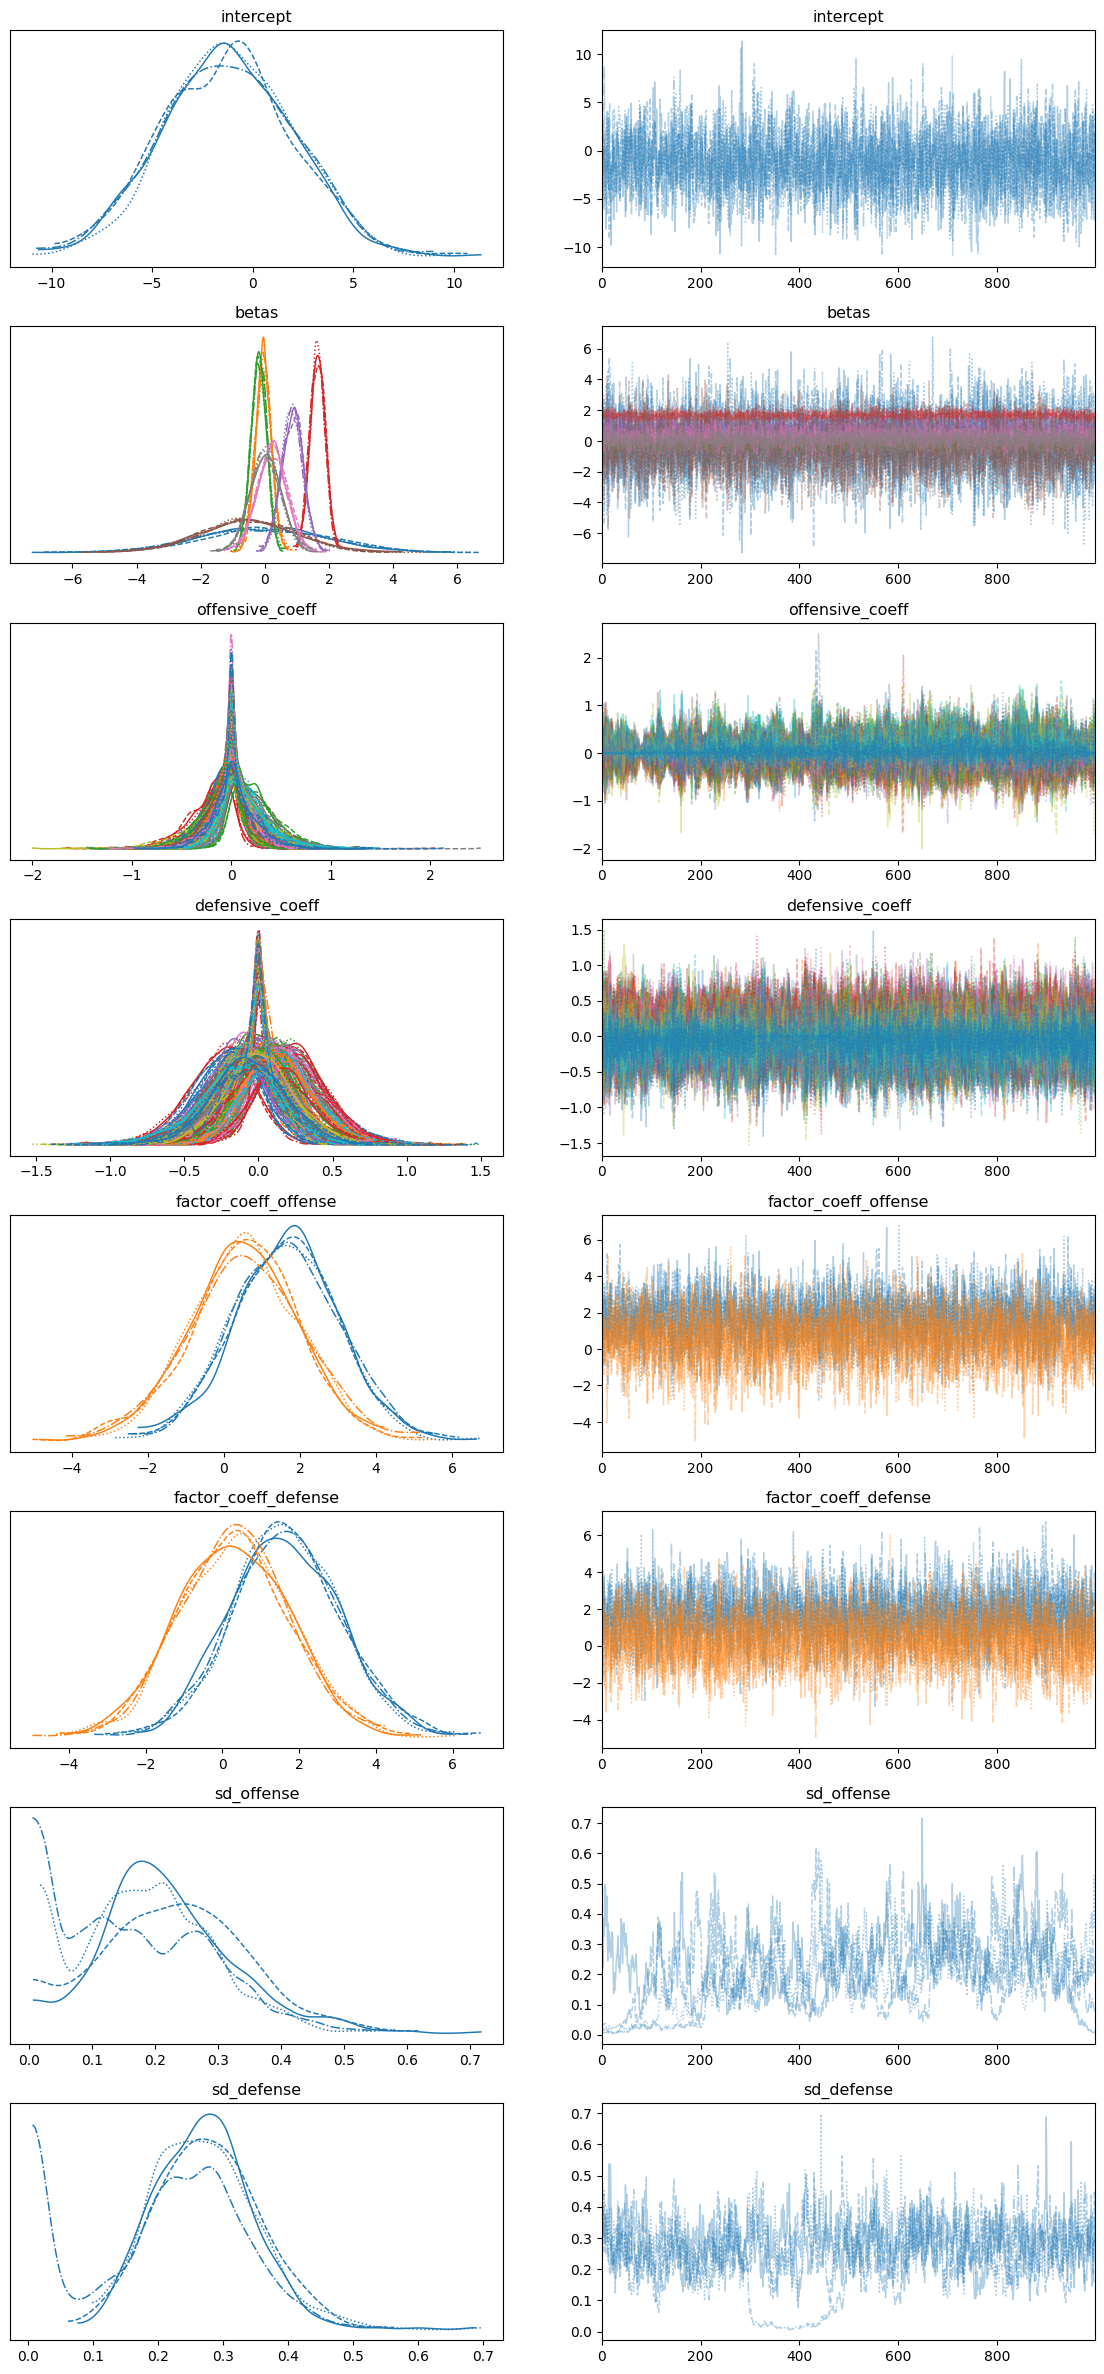

In [49]:
fig,ax = plt.subplots(8, 2, figsize=(14,30))
plt.subplots_adjust(hspace=0.25)
az.plot_trace(trace_full_model_normal, axes = ax)
plt.show()

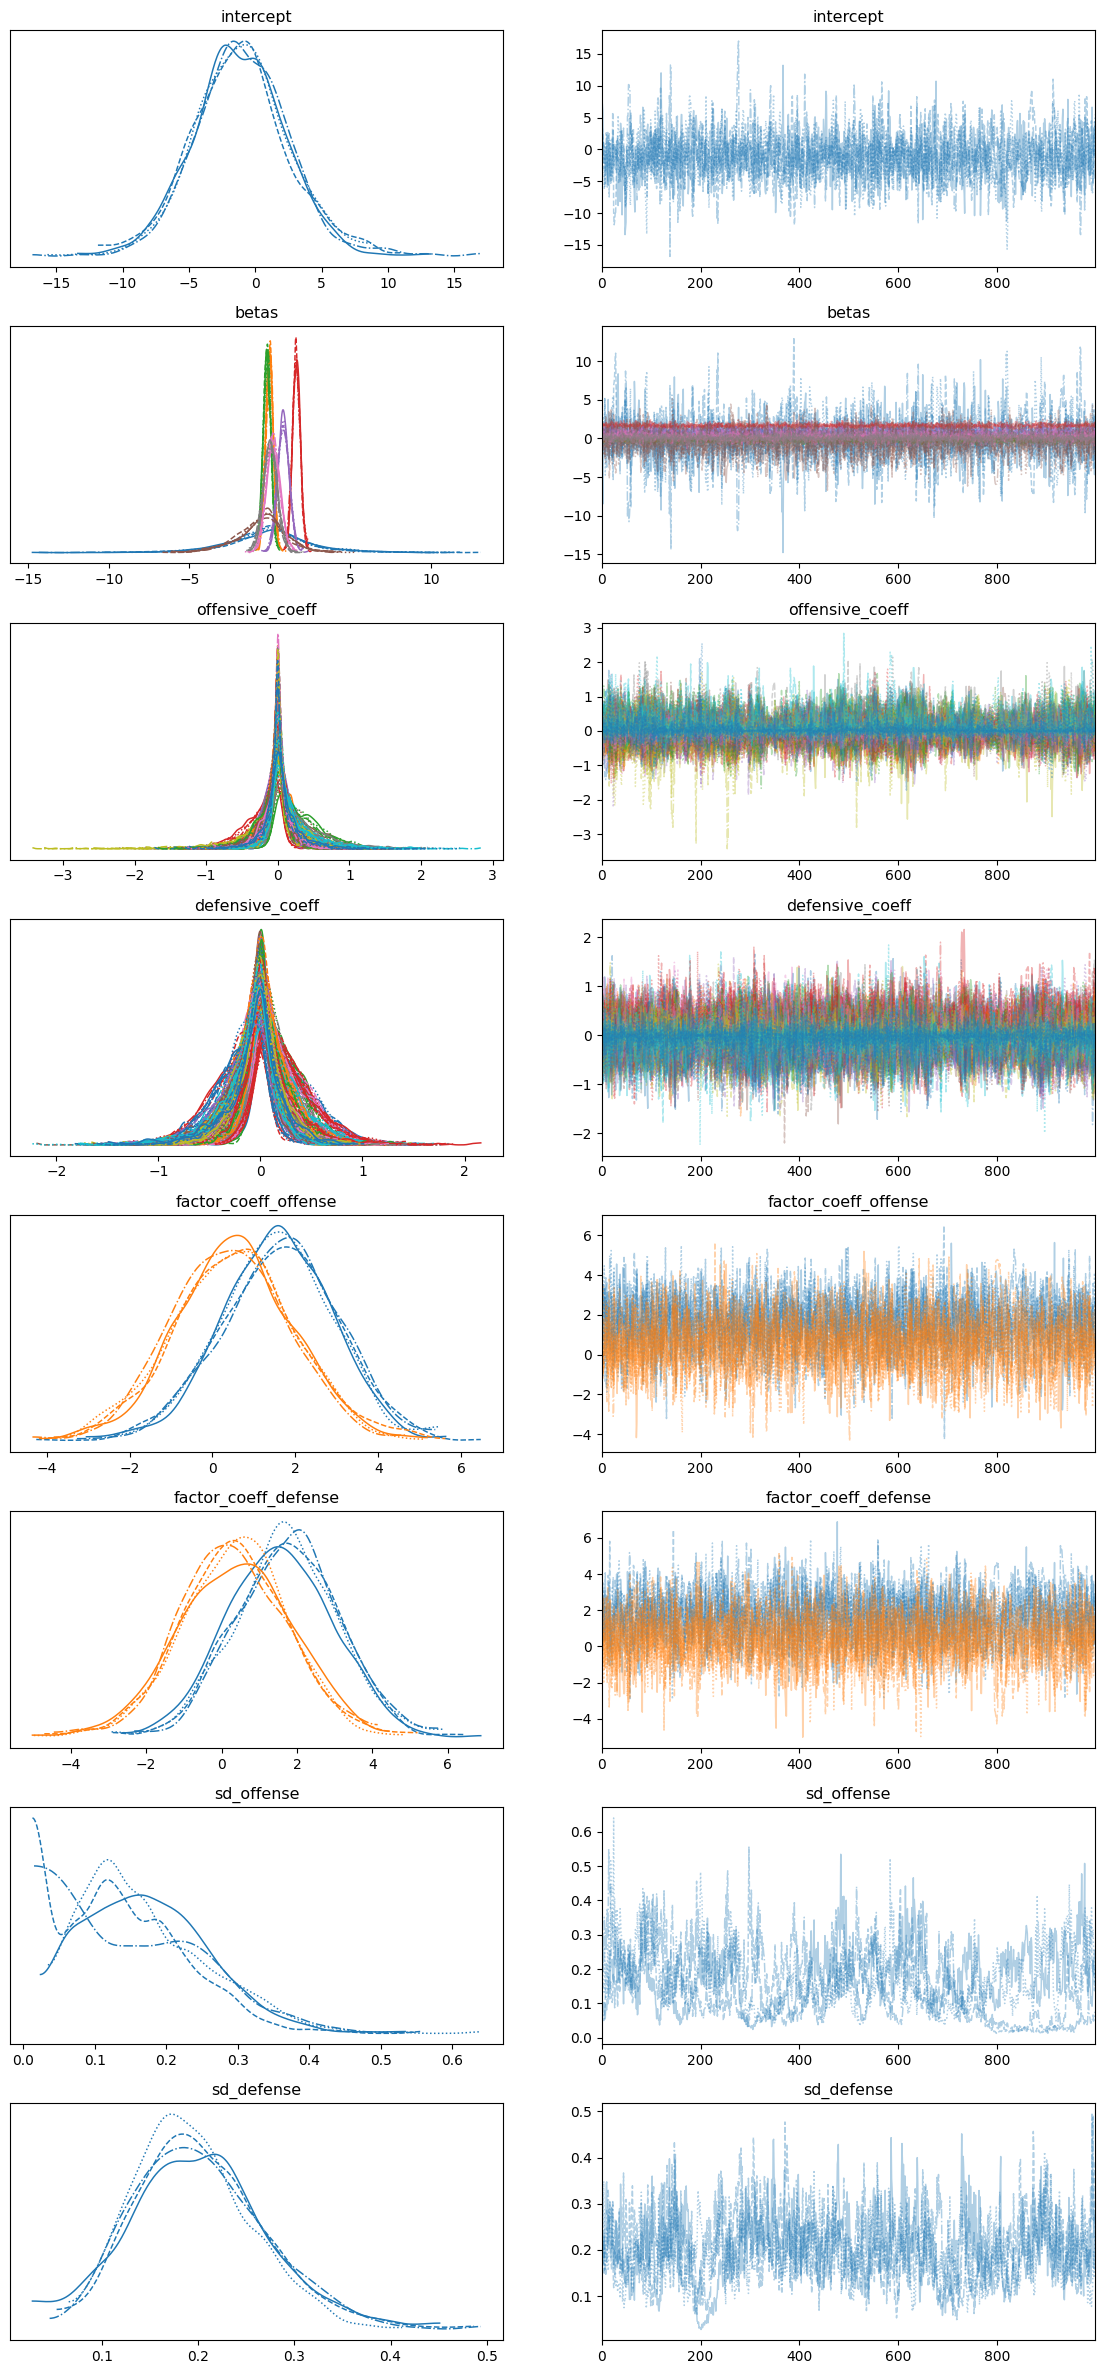

In [69]:
fig,ax = plt.subplots(8, 2, figsize=(14,30))
plt.subplots_adjust(hspace=0.25)
az.plot_trace(trace_full_model_laplace, axes=ax, compact=True)
plt.show()

In [50]:
az.summary(trace_full_model_normal, var_names=['betas'], hdi_prob=0.94)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
betas[Intercept]                  -0.057  1.984  -3.724    3.678      0.030   
betas[Period_2]                   -0.048  0.253  -0.540    0.416      0.004   
betas[Period_3]                   -0.186  0.242  -0.673    0.242      0.004   
betas[Entry_Type_Carried]          1.648  0.238   1.221    2.122      0.007   
betas[Entry_Type_Played]           0.856  0.335   0.264    1.525      0.005   
betas[Team_Women - United States] -0.524  1.473  -3.310    2.200      0.023   
betas[us_powerplay]                0.220  0.451  -0.619    1.060      0.007   
betas[canada_powerplay]            0.018  0.476  -0.897    0.873      0.007   

                                   mcse_sd  ess_bulk  ess_tail  r_hat  
betas[Intercept]                     0.030    4230.0    3142.0   1.00  
betas[Period_2]                      0.004    4138.0    2995.0   1.00  
betas[Period_3]                      0.003    3917.0    2820.0   1.00  
betas[Entry_Type_Carried]            0.005    1183.0    2842.0   1.01  
betas[Entry_Type_Played]             0.004    3990.0    3347.0   1.00  
betas[Team_Women - United States]    0.024    4133.0    2853.0   1.00  
betas[us_powerplay]                  0.006    3674.0    3215.0   1.00  
betas[canada_powerplay]              0.006    4163.0    3502.0   1.00

In [ ]:
az.summary(trace_full_model_laplace, var_names=['betas'], hdi_prob=0.94)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
betas[Intercept]                   0.000  2.714  -5.314    5.193      0.061   
betas[Period_2]                   -0.032  0.235  -0.466    0.411      0.005   
betas[Period_3]                   -0.178  0.224  -0.607    0.219      0.005   
betas[Entry_Type_Carried]          1.609  0.235   1.155    2.040      0.009   
betas[Entry_Type_Played]           0.785  0.347   0.118    1.414      0.013   
betas[Team_Women - United States] -0.404  1.450  -3.259    2.279      0.032   
betas[us_powerplay]                0.216  0.432  -0.605    1.014      0.011   
betas[canada_powerplay]            0.010  0.433  -0.842    0.807      0.010   

                                   mcse_sd  ess_bulk  ess_tail  r_hat  
betas[Intercept]                     0.067    2165.0    1330.0   1.01  
betas[Period_2]                      0.004    2157.0    2129.0   1.00  
betas[Period_3]                      0.003    2438.0    2653.0   1.00  
betas[Entry_Type_Carried]            0.006     704.0     955.0   1.01  
betas[Entry_Type_Played]             0.009     688.0    1370.0   1.01  
betas[Team_Women - United States]    0.027    2008.0    2224.0   1.01  
betas[us_powerplay]                  0.008    1436.0    1694.0   1.00  
betas[canada_powerplay]              0.007    2057.0    1977.0   1.00

<Axes: >

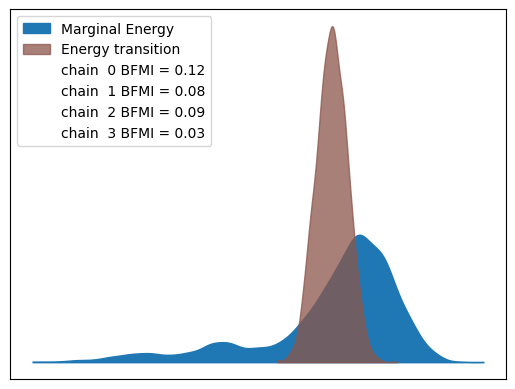

In [51]:
az.plot_energy(trace_full_model_normal)

<Axes: >

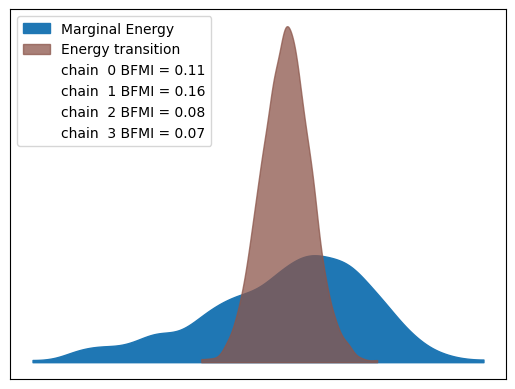

In [53]:
az.plot_energy(trace_full_model_laplace)

In [54]:
with prelim_model:
    pm.compute_log_likelihood(trace_prelim_model)

with full_model_normal:
    pm.compute_log_likelihood(trace_full_model_normal)

with full_model_laplace:
    pm.compute_log_likelihood(trace_full_model_laplace)

In [94]:
with prelim_model_players:
    pm.compute_log_likelihood(trace_prelim_model_players)

In [95]:
loo_result_prelim = az.loo(trace_prelim_model, pointwise=True)
loo_result_prelim_players = az.loo(trace_prelim_model_players, pointwise=True)
loo_result_full_normal = az.loo(trace_full_model_normal, pointwise=True)
loo_result_full_laplace = az.loo(trace_full_model_laplace, pointwise=True)

az.compare({"Preliminary Model": trace_prelim_model,"Preliminary Model with Players": trace_prelim_model_players , "Full Model Normal Priors": trace_full_model_normal, "Full Model Laplace Priors": trace_full_model_laplace}, ic='loo')

c:\Users\Matth\anaconda3\lib\site-packages\arviz\stats\stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
c:\Users\Matth\anaconda3\lib\site-packages\arviz\stats\stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


rank    elpd_loo      p_loo  elpd_diff  \
Full Model Normal Priors           0 -324.045792  33.483617   0.000000   
Full Model Laplace Priors          1 -324.661898  34.605114   0.616106   
Preliminary Model with Players     2 -328.402654  18.261857   4.356862   
Preliminary Model                  3 -328.656363   7.777275   4.610572   

                                      weight        se       dse  warning  \
Full Model Normal Priors        7.348686e-01  9.401646  0.000000    False   
Full Model Laplace Priors       5.385650e-16  9.420691  0.305400    False   
Preliminary Model with Players  2.651314e-01  9.024636  4.358020    False   
Preliminary Model               0.000000e+00  8.864605  4.051871    False   

                               scale  
Full Model Normal Priors         log  
Full Model Laplace Priors        log  
Preliminary Model with Players   log  
Preliminary Model                log

c:\Users\Matth\anaconda3\lib\site-packages\arviz\stats\stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
c:\Users\Matth\anaconda3\lib\site-packages\arviz\stats\stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
c:\Users\Matth\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

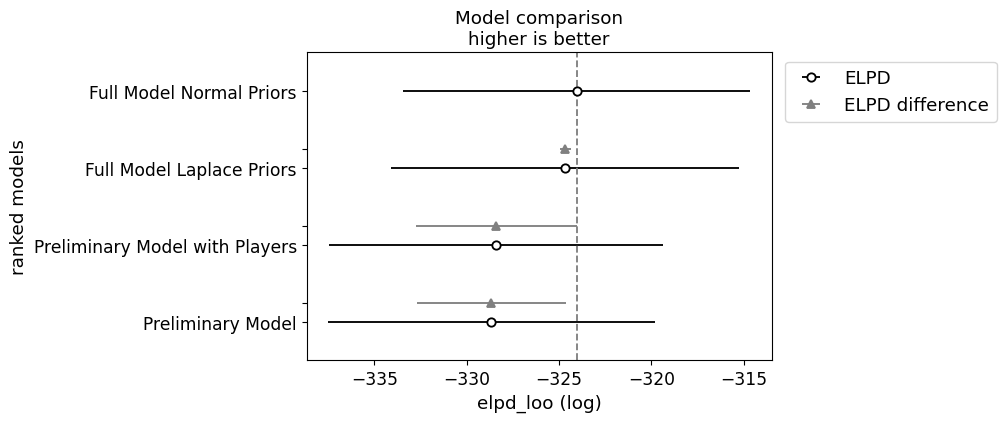

In [97]:
az.plot_compare(az.compare({"Preliminary Model": trace_prelim_model,"Preliminary Model with Players": trace_prelim_model_players, "Full Model Normal Priors": trace_full_model_normal, "Full Model Laplace Priors": trace_full_model_laplace}),
                insample_dev=False)

In [59]:
# Calculate summary statistics for coefficients
def plot_rankings(trace):
    summary_offensive = az.summary(trace, var_names=['offensive_coeff'], hdi_prob=0.94)
    summary_offensive = summary_offensive.assign(names=offensive_dataset.columns)

    summary_defensive = az.summary(trace, var_names=['defensive_coeff'], hdi_prob=0.94)
    summary_defensive = summary_defensive.assign(names=offensive_dataset.columns)

    # Sort the summary by mean values
    summary_sorted_offensive = summary_offensive.sort_values(by='mean')
    summary_sorted_defensive = summary_defensive.sort_values(by='mean')

    # Extract means and HDI intervals after sorting
    means_offensive, means_defensive = summary_sorted_offensive['mean'], summary_sorted_defensive['mean']
    hdi_lower_offensive, hdi_lower_defensive = summary_sorted_offensive['hdi_3%'], summary_sorted_defensive['hdi_3%']
    hdi_upper_offensive, hdi_upper_defensive = summary_sorted_offensive['hdi_97%'] , summary_sorted_defensive['hdi_97%']

    # Calculate errors from mean to lower and upper bounds
    errors_offensive = [means_offensive - hdi_lower_offensive, hdi_upper_offensive - means_offensive]
    errors_defensive = [means_defensive - hdi_lower_defensive, hdi_upper_defensive - means_defensive]

    # Generate a sequence of player names or IDs based on the sorted order
    player_names_sorted_offensive = summary_sorted_offensive.names
    player_names_sorted_defensive = summary_sorted_defensive.names

    # Create error bars
    plt.figure(figsize=(12, 8))
    plt.errorbar(range(len(means_offensive)), means_offensive, yerr=errors_offensive, fmt='o', capsize=5, capthick=2, color='darkblue')

    # Update the x-ticks to reflect the sorted player names
    plt.xticks(range(len(player_names_sorted_offensive)), player_names_sorted_offensive, rotation='vertical')

    plt.xlabel('Player')
    plt.ylabel('Offensive Skill Estimate')
    plt.title('Offensive Skill Estimates with 94% HDI, Sorted by Mean')
    plt.tight_layout()  # Adjust layout to make room for the rotated labels
    plt.show()


    # Create error bars
    plt.figure(figsize=(12, 8))
    plt.errorbar(range(len(means_defensive)), means_defensive, yerr=errors_defensive, fmt='o', capsize=5, capthick=2, color='darkblue')

    # Update the x-ticks to reflect the sorted player names
    plt.xticks(range(len(player_names_sorted_defensive)), player_names_sorted_defensive, rotation='vertical')

    plt.xlabel('Player')
    plt.ylabel('Defensive Skill Estimate')
    plt.title('Defensive Skill Estimates with 94% HDI, Sorted by Mean')
    plt.tight_layout()  # Adjust layout to make room for the rotated labels
    plt.show()


C:\Users\Matth\AppData\Local\Temp\ipykernel_49992\3839305178.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(i, means_offensive[i], yerr=[[errors_offensive[0][i]], [errors_offensive[1][i]]],


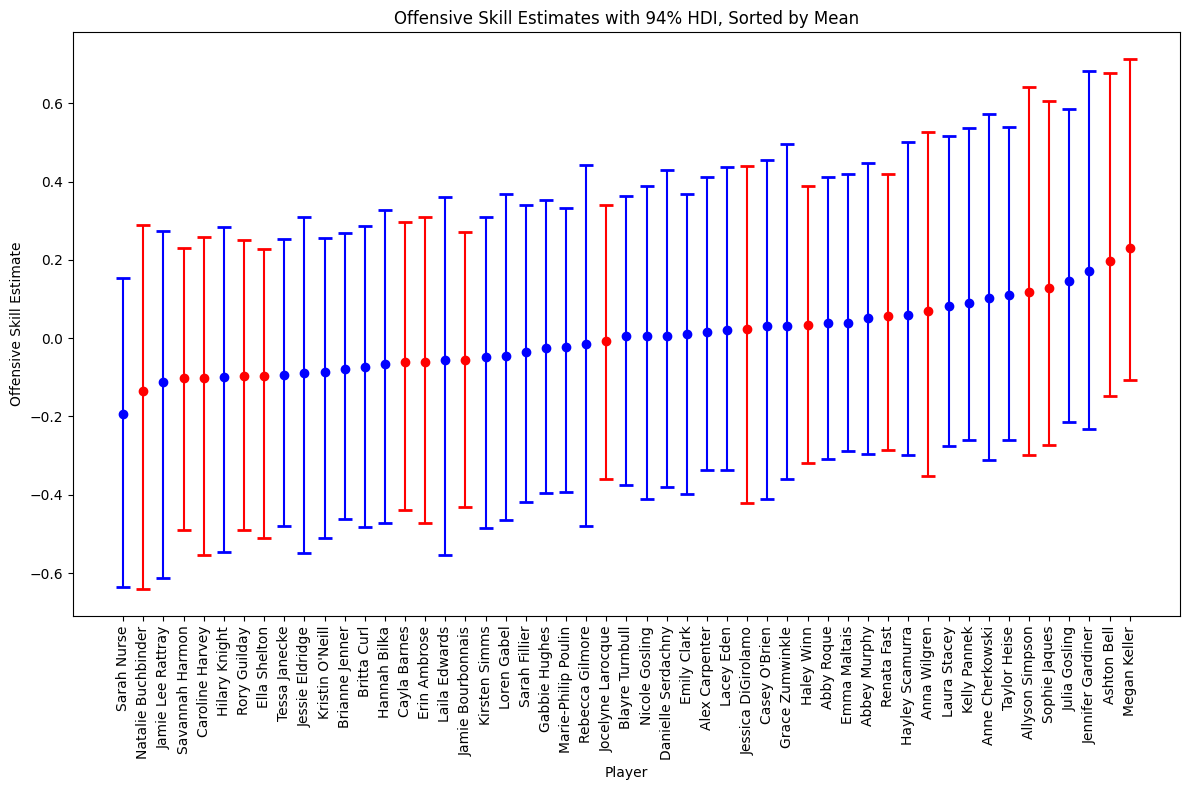

C:\Users\Matth\AppData\Local\Temp\ipykernel_49992\3839305178.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(i, means_defensive[i], yerr=[[errors_defensive[0][i]], [errors_defensive[1][i]]],


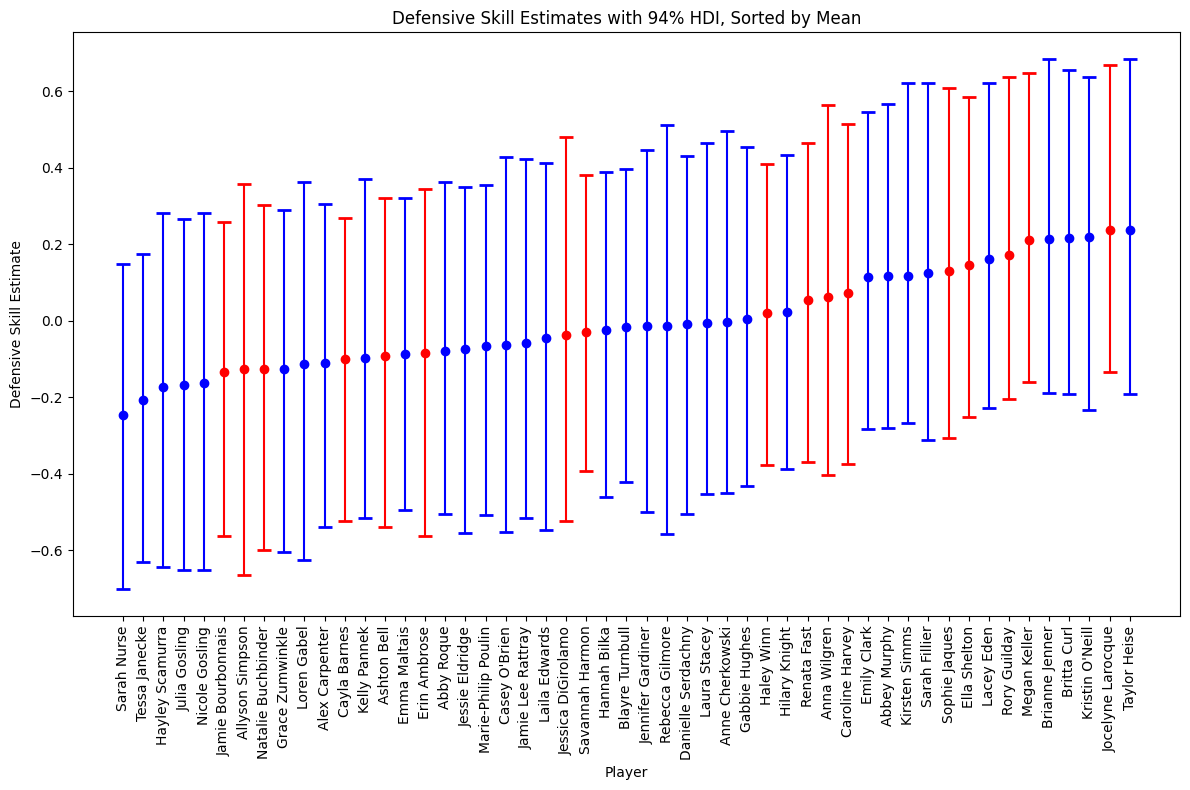

In [100]:
plot_rankings(trace_full_model_normal)

C:\Users\Matth\AppData\Local\Temp\ipykernel_49992\3839305178.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(i, means_offensive[i], yerr=[[errors_offensive[0][i]], [errors_offensive[1][i]]],


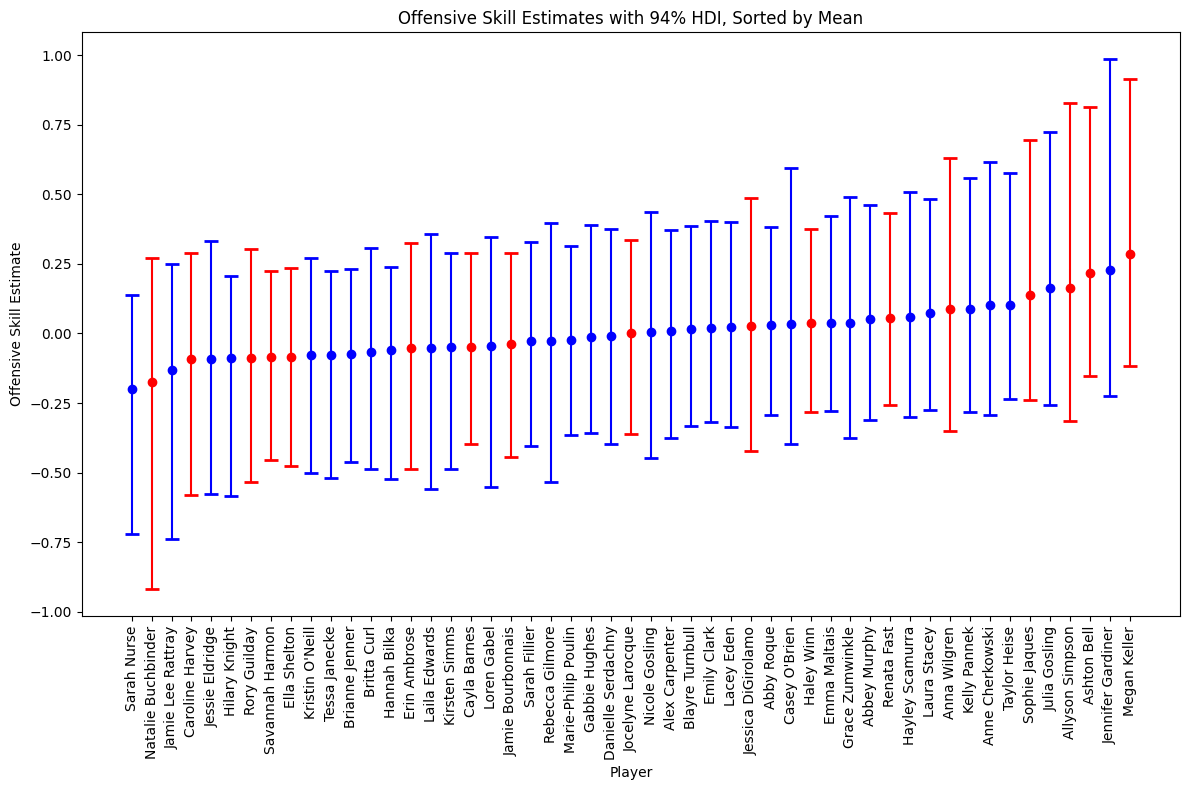

C:\Users\Matth\AppData\Local\Temp\ipykernel_49992\3839305178.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(i, means_defensive[i], yerr=[[errors_defensive[0][i]], [errors_defensive[1][i]]],


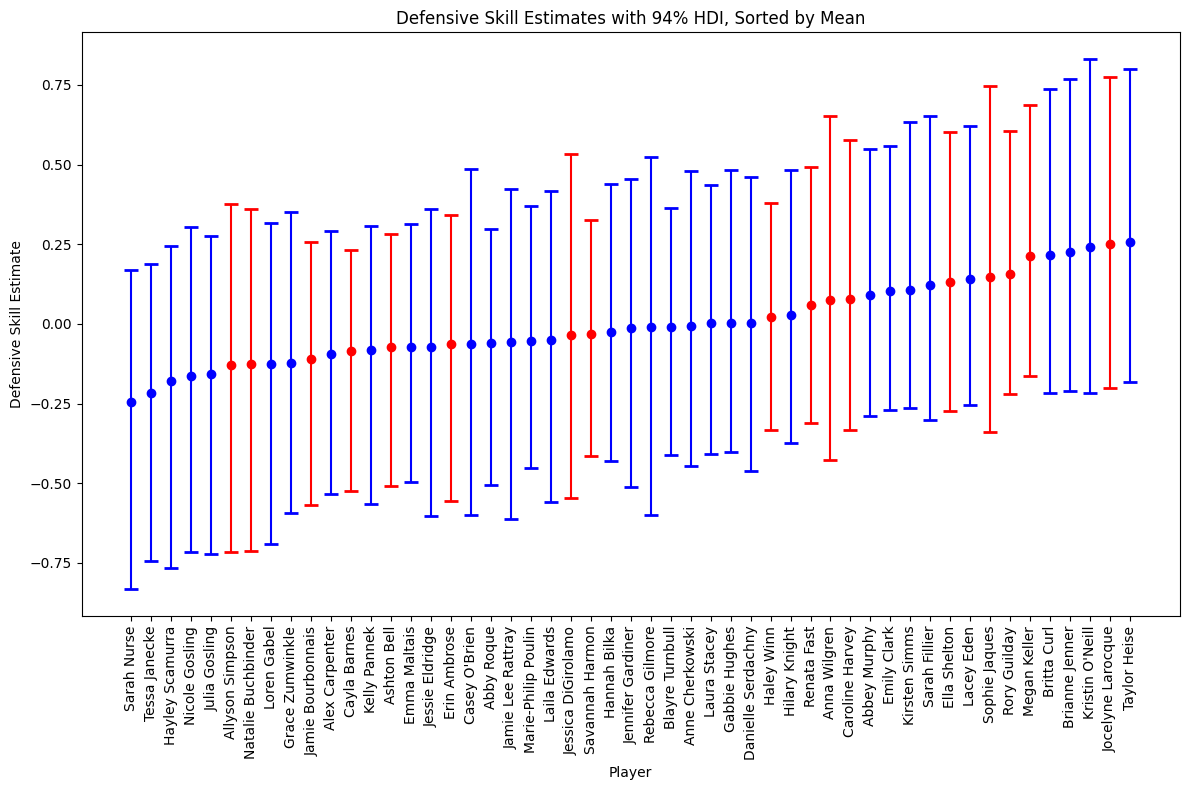

In [102]:
plot_rankings(trace_full_model_laplace)